# Settings

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/My Drive/Notebooks/transformers-project"

Mounted at /content/drive


In [ ]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [ ]:
import os
import json
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn import metrics
from datasets import load_dataset
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Create dataset


In [ ]:
BBQ_PATH = "oskarvanderwal/bbq"
DS_CATEGORIES = ['Gender_identity', 'Race_ethnicity', 'Religion']
DS_CONTEXTS = ['ambig', 'disambig']

In [ ]:


def load_bbq_category(category: str, context: str):
    assert category in DS_CATEGORIES
    assert context in DS_CONTEXTS

    dataset = load_dataset(BBQ_PATH, category)['test']
    dataset = dataset.filter(lambda example: example["context_condition"] == context)

    return dataset

gender_ambig = load_bbq_category('Gender_identity', 'ambig')
race_ambig = load_bbq_category('Race_ethnicity', 'ambig')
religion_ambig = load_bbq_category('Religion', 'ambig')
gender_disambig = load_bbq_category('Gender_identity', 'disambig')
race_disambig = load_bbq_category('Race_ethnicity', 'disambig')
religion_disambig = load_bbq_category('Religion', 'disambig')

Generating test split:   0%|          | 0/5672 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6880 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
def get_all_stereotyped_groups(dataset):
  return {group for metadata in dataset['additional_metadata']
                for group in metadata['stereotyped_groups']}

print('Gender_identity - Ambig')
print(f'Length: {len(gender_ambig)}')
print(f'Stereotyped groups: {get_all_stereotyped_groups(gender_ambig)}')
print()
print('Race_ethnicity - Ambig')
print(f'Length: {len(race_ambig)}')
print(f'Stereotyped groups: {get_all_stereotyped_groups(race_ambig)}')
print()
print('Religion - Ambig')
print(f'Length: {len(religion_ambig)}')
print(f'Stereotyped groups: {get_all_stereotyped_groups(religion_ambig)}')

Gender_identity - Ambig
Length: 2836
Stereotyped groups: {'transgender women', 'M', 'F', 'transgender men', 'Transgender women', 'trans'}

Race_ethnicity - Ambig
Length: 3440
Stereotyped groups: {'Middle Eastern', 'Hispanic', 'Latino', 'Roma', 'African American', 'Jewish', 'Asian', 'Black', 'Native American', 'Arab'}

Religion - Ambig
Length: 600
Stereotyped groups: {'Catholic', 'Mormon', 'Atheist', 'Muslim', 'Christian', 'Orthodox', 'Jewish', 'Hindu'}


In [ ]:
def check_single_desired_subgroup(dataset, desired_subgroups):
  multi_groups = 0
  for e in dataset:
    e_subgroups = set([subgroup for subgroup in e['additional_metadata']['stereotyped_groups']
                       if subgroup in desired_subgroups])
    if len(e_subgroups) > 1:
      multi_groups += 1

  print(f'Number of examples with more than one desired subgroup: {multi_groups}')

gender_subgroups = ['M', 'F', 'trans']
print(f'Gender')
check_single_desired_subgroup(gender_ambig, gender_subgroups)

race_subgroups = ['Asian', 'Arab', 'Jewish', 'Black']
print(f'Race')
check_single_desired_subgroup(race_ambig, race_subgroups)

religion_subgroups = ['Muslim', 'Christian', 'Jewish', 'Hindu']
print(f'Religion')
check_single_desired_subgroup(religion_ambig, religion_subgroups)

Gender
Number of examples with more than one desired subgroup: 0
Race
Number of examples with more than one desired subgroup: 0
Religion
Number of examples with more than one desired subgroup: 0


In [ ]:
def create_subgroup_col(example):
  return example['additional_metadata']['stereotyped_groups']

all_ds_names = [f'{category}_{context}' for category in DS_CATEGORIES for context in DS_CONTEXTS]
ds_already_done = [f.replace(".csv", "") for f in os.listdir(os.path.join(root_dir, 'data')) if f.endswith('.csv')]
missing_datasets = [subgroup for subgroup in all_ds_names if subgroup not in ds_already_done]

if len(missing_datasets) == 0:
  print("All dataset have already been saved")

for missing_ds in missing_datasets:
  category, context = missing_ds.rsplit('_', 1)
  dataset = load_bbq_category(category, context)
  df = dataset.to_pandas()
  df['subgroup'] = df.apply(create_subgroup_col, axis=1)
  df = df[['example_id', 'context', 'question', 'ans0', 'ans1', 'ans2', 'label', 'subgroup']]
  df.to_csv(os.path.join(root_dir, 'data', f'{category}_{context}.csv'))

All dataset have already been saved


# Calculate scores for all models

## Model loading

In [ ]:
def load_model_and_tokenizer(model_path: str):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id
    model.half().to(device)

    return model, tokenizer

## Prompts

In [ ]:
ans_num_to_char = {0: 'A', 1: 'B', 2: 'C'}

def make_full_prompt(example, option=None):
  answer = ans_num_to_char[example['label']] if option is None else option
  return f"""{example['context']}
{example['question']}
(A) {example['ans0']}
(B) {example['ans1']}
(C) {example['ans2']}
The correct answer is: {answer}"""

def get_answer_options(example):
  options = ['A', 'B', 'C']
  return [make_full_prompt(example, option) for option in options]

## Scores

In [ ]:
def get_probs(model, tokenizer, question):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_outputs = []
    all_input_ids = []
    input_texts = get_answer_options(question)
    for text in input_texts:
        input_ids = tokenizer(text, padding=True, return_tensors="pt").input_ids.to(device)
        outputs = model(input_ids)
        logits = outputs.logits.detach().cpu()
        all_outputs.append(logits)
        all_input_ids.append(input_ids.detach().cpu())
        del outputs, input_ids
        torch.cuda.empty_cache()

    all_outputs = torch.concat(all_outputs, 0)[:, -2:-1, :]  # We take the logit corresponding to the option token
    all_input_ids = torch.concat(all_input_ids, 0)[:, -1:]  # We also include the token id for the options
    probs = torch.log_softmax(all_outputs.float(), dim=-1).detach().cpu()  # Log softmax scores
    torch.cuda.empty_cache()

    gen_probs = torch.gather(probs, 2, all_input_ids[:, :, None]).squeeze(-1)

    softmax_probs = torch.nn.functional.softmax(gen_probs[:, 0], -1)

    return softmax_probs

## Run model on dataset

In [ ]:
def run_model_on_df(model, tokenizer, df):
  records = []

  for _, example in tqdm(df.iterrows(), total=df.shape[0]):
    record = {
        'example_id': example['example_id'],
        'model_scores': get_probs(model, tokenizer, example).tolist()
    }
    records.append(record)
  return pd.DataFrame(records)

def run_model(model_checkpoint, root_dir):
    model_name = model_checkpoint.split('/')[-1]
    dir_path = os.path.join(root_dir, model_name)
    os.makedirs(dir_path, exist_ok=True)

    all_ds_names = [f'{category}_{context}' for category in DS_CATEGORIES for context in DS_CONTEXTS]
    ds_already_done = [f.replace(".csv", "") for f in os.listdir(dir_path) if f.endswith('.csv')]
    missing_datasets = [subgroup for subgroup in all_ds_names if subgroup not in ds_already_done]

    if len(missing_datasets) == 0:
      print("All scores have already been calculated")

    model, tokenizer = load_model_and_tokenizer(model_checkpoint)

    for missing_subgroup in missing_datasets:
      category, context = missing_subgroup.rsplit('_', 1)
      data_df = pd.read_csv(os.path.join(root_dir, 'data', f'{category}_{context}.csv'))
      print(f'Running for {category}_{context}')
      scores_df = run_model_on_df(model, tokenizer, data_df)
      scores_df.to_csv(os.path.join(dir_path, f'{category}_{context}.csv'))
      torch.cuda.empty_cache()

    del model, tokenizer
    print("Done")

## Run all models

In [ ]:
run_model("google/gemma-7b", root_dir)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Running for Gender_identity_ambig


Generating test split:   0%|          | 0/5672 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

100%|██████████| 2836/2836 [17:52<00:00,  2.64it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Gender_identity_disambig


Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

100%|██████████| 2836/2836 [23:40<00:00,  2.00it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_ambig


Generating test split:   0%|          | 0/6880 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

100%|██████████| 3440/3440 [25:10<00:00,  2.28it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_disambig


Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

100%|██████████| 3440/3440 [34:25<00:00,  1.67it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_ambig


Generating test split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

100%|██████████| 600/600 [04:28<00:00,  2.23it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_disambig


Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

100%|██████████| 600/600 [05:58<00:00,  1.67it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


In [ ]:
run_model("mistralai/Mistral-7B-v0.1", root_dir)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Running for Gender_identity_disambig


Generating test split:   0%|          | 0/5672 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

100%|██████████| 2836/2836 [14:39<00:00,  3.22it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_ambig


Generating test split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

100%|██████████| 3440/3440 [15:52<00:00,  3.61it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_disambig


Filter:   0%|          | 0/6880 [00:00<?, ? examples/s]

100%|██████████| 3440/3440 [20:02<00:00,  2.86it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_ambig


Generating test split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

100%|██████████| 600/600 [02:46<00:00,  3.61it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_disambig


Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

100%|██████████| 600/600 [03:29<00:00,  2.86it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Done


In [ ]:
run_model("meta-llama/Meta-Llama-3-8B", root_dir)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

Running for Gender_identity_ambig


Filter:   0%|          | 0/5672 [00:00<?, ? examples/s]

100%|██████████| 2836/2836 [16:08<00:00,  2.93it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Gender_identity_disambig


100%|██████████| 2836/2836 [19:40<00:00,  2.40it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_ambig


100%|██████████| 3440/3440 [21:37<00:00,  2.65it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Race_ethnicity_disambig


100%|██████████| 3440/3440 [26:42<00:00,  2.15it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_ambig


100%|██████████| 600/600 [03:43<00:00,  2.68it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Running for Religion_disambig


100%|██████████| 600/600 [04:38<00:00,  2.15it/s]
<ipython-input-7-0a376eb8becb>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float)
<ipython-input-7-0a376eb8becb>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-7-0a376eb8becb>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


Done


# Calculate conformal prediction

In [ ]:
def calibrate_lac(scores, targets, alpha=0.1, return_dist=False):
    """
    Estimates the 1-alpha quantile on held-out calibration data.
    The score function is `1 - max(softmax_score)`.

    Arguments:
        scores: softmax scores of the calibration set
        targets: corresponding labels of the calibration set
        alpha: parameter for the desired coverage level (1-alpha)

    Returns:
       qhat: the estimated quantile
       score_dist: the score distribution
    """
    assert scores.size(0) == targets.size(0)
    assert targets.size(0)
    n = torch.tensor(targets.size(0))
    assert n

    score_dist = torch.take_along_dim(1 - scores, targets.unsqueeze(1), 1).flatten()
    assert (
        0 <= torch.ceil((n + 1) * (1 - alpha)) / n <= 1
    ), f"{alpha=} {n=} {torch.ceil((n+1)*(1-alpha))/n=}"
    qhat = torch.quantile(
        score_dist, torch.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
    )
    return (qhat, score_dist) if return_dist else qhat

def inference_lac(scores, qhat, allow_empty_sets=False):
    """
    Makes prediction sets on new test data

    Arguments:
        scores: softmax scores of the test set
        qhat: estimated quantile of the calibration set from the `calirbate_lac` function
        allow_empty_sets: if True allow a prediction set to contain no predictions (will then satisfy upper bound of marginal coverage)

    Returns:
       prediction_sets: boolean mask of prediction sets (True if class is included in the prediction set; otherwise False)
    """
    scores = scores.clone().detach().float()
    n = scores.size(0)

    elements_mask = scores >= (1 - qhat)

    if not allow_empty_sets:
        elements_mask[torch.arange(n), scores.argmax(1)] = True

    prediction_sets = elements_mask

    return prediction_sets

def get_coverage(psets, targets):
    """
    Calculates empirical coverage of prediction sets

    Arguments:
        psets: prediction sets of test set
        targets: ground true labels of test set
        precision: rounding precision

    Returns:
       coverage: how many times the answer is in the prediction set
    """
    psets = psets.clone().detach()
    targets = targets.clone().detach()
    n = psets.shape[0]
    coverage = psets[torch.arange(n), targets].float().mean().item()
    return coverage

def get_size(psets):
    """
    Calculates empirical set sizes of prediction sets (can consider as the average uncertainty of the model)

    Arguments:
        psets: prediction sets of test set
        precision: rounding precision

    Returns:
       size: how many prediction does each set contain on average
    """
    psets = psets.clone().detach()
    size = psets.sum(1).float().mean().item()
    return size

In [ ]:
def handle_model_scores(score_text):
  return np.fromstring(score_text[1:-1], sep=',', dtype=np.float32)

def merge_data_and_scores(root_dir, model_name, category, context):
  df_data = pd.read_csv(os.path.join(root_dir, 'data', f'{category}_{context}.csv'))
  df_data = df_data.drop(columns=[col for col in df_data.columns if 'Unnamed' in col])
  df_scores = pd.read_csv(os.path.join(root_dir, model_name, f'{category}_{context}.csv'))
  df_scores = df_scores.drop(columns=[col for col in df_scores.columns if 'Unnamed' in col])
  df_merged = pd.merge(df_data, df_scores, on="example_id")
  df_merged['model_scores'] = df_merged['model_scores'].apply(handle_model_scores)
  return df_merged

def split_scores_and_targets(scores, targets, ratio: float =0.5):
    torch.manual_seed(0) # for reproducability
    n = int(len(scores) * ratio)
    idx = torch.randperm(scores.shape[0])

    calib_scores = scores[idx][:n, :]
    eval_scores = scores[idx][n:, :]
    calib_targets = targets[idx][:n]
    eval_targets = targets[idx][n:]

    return calib_scores, eval_scores, calib_targets, eval_targets, idx[:n]

category_to_subgroups_map = {
    'Gender_identity': ['M', 'F', 'trans'],
    'Race_ethnicity': ['Asian', 'Arab', 'Jewish', 'Black'],
    'Religion': ['Muslim', 'Christian', 'Jewish', 'Hindu']
}

def calculate_cf_metrics(model_name):
  all_results = {}
  for category in DS_CATEGORIES:
    for context in DS_CONTEXTS:
      subgroups = category_to_subgroups_map[category]
      df_merged = merge_data_and_scores(root_dir, model_name, category, context)
      for subgroup in subgroups:
        df_subgroup = df_merged[df_merged['subgroup'].apply(lambda x: subgroup in x)]
        scores = df_subgroup['model_scores'].to_numpy()
        scores = np.stack(scores, axis=0)
        scores = torch.from_numpy(scores).float()
        targets = torch.from_numpy(df_subgroup['label'].to_numpy()).long()
        calib_scores, eval_scores, calib_targets, eval_targets, calib_idx = split_scores_and_targets(scores, targets)

        # save `calib_idx` to dir as numpy array for later usage
        np.save(os.path.join(root_dir, model_name, f'{category}_{context}_calib_idx.npy'), calib_idx.numpy())

        qhat = calibrate_lac(calib_scores, calib_targets)
        eval_psets = inference_lac(eval_scores, qhat)
        avg_size = get_size(eval_psets)
        coverage = get_coverage(eval_psets, eval_targets)
        results = {
              'qhat': qhat.item(),
              'avg_size': avg_size,
              'coverage': coverage,
              'subgroup_size': len(df_subgroup)
        }
        all_results[f'{category}_{context}_{subgroup}'] = results

  all_results = pd.DataFrame.from_dict(all_results, orient='index')
  all_results.to_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  return all_results

In [ ]:
calculate_cf_metrics("gemma-7b")

,qhat,avg_size,coverage,subgroup_size
Gender_identity_ambig_M,0.934810,2.885246,0.920765,732
Gender_identity_ambig_F,0.912951,2.815789,0.905502,1672
Gender_identity_ambig_trans,0.888543,2.856482,0.907407,432
Gender_identity_disambig_M,0.778612,1.806011,0.926230,732
Gender_identity_disambig_F,0.772669,1.808612,0.909091,1672
Gender_identity_disambig_trans,0.806699,2.111111,0.930556,432
Race_ethnicity_ambig_Asian,0.943649,2.937500,0.945833,480
Race_ethnicity_ambig_Arab,0.871044,2.837500,0.908333,480
Race_ethnicity_ambig_Jewish,0.927360,3.000000,1.000000,20
Race_ethnicity_ambig_Black,0.915051,2.867021,0.902128,1880


In [ ]:
calculate_cf_metrics('Meta-Llama-3-8B')

,qhat,avg_size,coverage,subgroup_size
Gender_identity_ambig_M,0.715446,1.784153,0.893443,732
Gender_identity_ambig_F,0.745427,2.239234,0.909091,1672
Gender_identity_ambig_trans,0.764864,2.569444,0.939815,432
Gender_identity_disambig_M,0.797068,2.546448,0.912568,732
Gender_identity_disambig_F,0.765902,2.477273,0.909091,1672
Gender_identity_disambig_trans,0.779668,2.638889,0.939815,432
Race_ethnicity_ambig_Asian,0.786103,2.650000,0.825000,480
Race_ethnicity_ambig_Arab,0.783464,2.816667,0.900000,480
Race_ethnicity_ambig_Jewish,0.775941,2.700000,1.000000,20
Race_ethnicity_ambig_Black,0.795867,2.678723,0.901064,1880


In [ ]:
calculate_cf_metrics('Mistral-7B-v0.1')

,qhat,avg_size,coverage,subgroup_size
Gender_identity_ambig_M,0.796304,2.030055,0.904372,732
Gender_identity_ambig_F,0.797161,2.057416,0.904306,1672
Gender_identity_ambig_trans,0.766051,2.055556,0.930556,432
Gender_identity_disambig_M,0.872731,2.420765,0.898907,732
Gender_identity_disambig_F,0.907646,2.592105,0.897129,1672
Gender_identity_disambig_trans,0.856500,2.430556,0.856481,432
Race_ethnicity_ambig_Asian,0.807924,2.300000,0.866667,480
Race_ethnicity_ambig_Arab,0.742986,1.762500,0.900000,480
Race_ethnicity_ambig_Jewish,0.833150,2.400000,0.900000,20
Race_ethnicity_ambig_Black,0.794005,2.045745,0.915957,1880


# Calculate AUC metrics

In [ ]:
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred, multi_class='ovr')
    except ValueError:
        return -1

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df['subgroup'].apply(lambda x: subgroup in x)]
    y_true = subgroup_examples[label].values
    y_pred = np.stack(subgroup_examples[model_name].to_numpy())
    return compute_auc(y_true, y_pred)

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    bpsns = []
    for i in range(3):
      # df_merged[df_merged]
      subgroup_negative_examples = df[df['subgroup'].apply(lambda x: subgroup in x)]
      subgroup_negative_examples = subgroup_negative_examples[subgroup_negative_examples[label] != i]
      # subgroup_negative_examples = df[(df[subgroup] == True) & (df[label] != i)]
      non_subgroup_positive_examples = df[df['subgroup'].apply(lambda x: subgroup not in x)]
      non_subgroup_positive_examples = non_subgroup_positive_examples[non_subgroup_positive_examples[label] == i]
      # non_subgroup_positive_examples = df[(df[subgroup] == False) & (df[label] == i)]
      examples = pd.concat([subgroup_negative_examples, non_subgroup_positive_examples])
      y_true = examples[label].values
      y_pred = np.stack(examples[model_name].to_numpy())
      bpsn = compute_auc(y_true, y_pred)
      bpsns.append(bpsn)
    return sum(bpsns)/len(bpsns)

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    bnsps = []
    for i in range(3):
      subgroup_positive_examples = df[df['subgroup'].apply(lambda x: subgroup in x)]
      subgroup_positive_examples = subgroup_positive_examples[subgroup_positive_examples[label] == i]
      # subgroup_positive_examples = df[(df[subgroup]== True) & (df[label] == i)]
      non_subgroup_negative_examples = df[df['subgroup'].apply(lambda x: subgroup not in x)]
      non_subgroup_negative_examples = non_subgroup_negative_examples[non_subgroup_negative_examples[label] != i]
      # non_subgroup_negative_examples = df[(df[subgroup] == False) & (df[label] != i)]
      examples = pd.concat([subgroup_positive_examples, non_subgroup_negative_examples])
      y_true = examples[label].values
      y_pred = np.stack(examples[model_name].to_numpy())
      bnsp = compute_auc(y_true, y_pred)
      bnsps.append(bnsp)
    return sum(bnsps)/len(bnsps)

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   scores_col,
                                   label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    results = {}
    for subgroup in subgroups:
        results[subgroup] = {
          'subgroup_auc': compute_subgroup_auc(dataset, subgroup, label_col, scores_col),
          'bpsn_auc': compute_bpsn_auc(dataset, subgroup, label_col, scores_col),
          'bnsp_auc': compute_bnsp_auc(dataset, subgroup, label_col, scores_col)
        }
    return results

def calculate_auc_metrics(model_name):
  all_results = {}
  for category in DS_CATEGORIES:
    for context in DS_CONTEXTS:
      subgroups = category_to_subgroups_map[category]
      df_merged = merge_data_and_scores(root_dir, model_name, category, context)

      results = compute_bias_metrics_for_model(df_merged, subgroups, 'model_scores', 'label')
      for subgroup, res in results.items():
        all_results[f'{category}_{context}_{subgroup}'] = res

  all_results = pd.DataFrame.from_dict(all_results, orient='index')
  all_results.to_csv(os.path.join(root_dir, model_name, f'auc_results.csv'))
  return all_results

In [ ]:
calculate_auc_metrics("gemma-7b")

,subgroup_auc,bpsn_auc,bnsp_auc
Gender_identity_ambig_M,0.219294,0.246425,0.269700
Gender_identity_ambig_F,0.301566,0.279170,0.252396
Gender_identity_ambig_trans,0.226043,0.255885,0.271217
Gender_identity_disambig_M,0.867824,0.870822,0.876051
Gender_identity_disambig_F,0.884917,0.878412,0.871825
Gender_identity_disambig_trans,0.866915,0.871040,0.875490
Race_ethnicity_ambig_Asian,0.205112,0.231044,0.257447
Race_ethnicity_ambig_Arab,0.362149,0.321250,0.287411
Race_ethnicity_ambig_Jewish,0.046458,0.119796,0.211819
Race_ethnicity_ambig_Black,0.260184,0.269847,0.279230


In [ ]:
calculate_auc_metrics('Meta-Llama-3-8B')

,subgroup_auc,bpsn_auc,bnsp_auc
Gender_identity_ambig_M,0.853970,0.823423,0.789743
Gender_identity_ambig_F,0.777676,0.787023,0.795852
Gender_identity_ambig_trans,0.697324,0.749835,0.783178
Gender_identity_disambig_M,0.568336,0.570099,0.579460
Gender_identity_disambig_F,0.590003,0.583290,0.577542
Gender_identity_disambig_trans,0.592583,0.588650,0.584739
Race_ethnicity_ambig_Asian,0.554952,0.579336,0.599041
Race_ethnicity_ambig_Arab,0.506473,0.561214,0.595887
Race_ethnicity_ambig_Jewish,0.470694,0.584034,0.607537
Race_ethnicity_ambig_Black,0.597742,0.603611,0.610010


In [ ]:
calculate_auc_metrics('Mistral-7B-v0.1')

,subgroup_auc,bpsn_auc,bnsp_auc
Gender_identity_ambig_M,0.850283,0.853014,0.855419
Gender_identity_ambig_F,0.864477,0.857887,0.851677
Gender_identity_ambig_trans,0.854219,0.850469,0.859646
Gender_identity_disambig_M,0.657435,0.605140,0.561143
Gender_identity_disambig_F,0.500577,0.544370,0.591801
Gender_identity_disambig_trans,0.625673,0.592878,0.569273
Race_ethnicity_ambig_Asian,0.767855,0.817664,0.852051
Race_ethnicity_ambig_Arab,0.935048,0.901705,0.871834
Race_ethnicity_ambig_Jewish,0.903175,0.868578,0.861035
Race_ethnicity_ambig_Black,0.857195,0.860817,0.865312


# Plots

## Create psets dataframe

In [ ]:
def create_psets_dataframe(model_name, category, context):
  df_merged = merge_data_and_scores(root_dir, model_name, category, context)
  calib_idx = np.load(os.path.join(root_dir, model_name, f'{category}_{context}_calib_idx.npy'))
  df_merged['is_calib'] = df_merged.index.isin(calib_idx)
  df_merged = df_merged[~df_merged['is_calib']] # Take only eval set
  df_results = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  subgroups = category_to_subgroups_map[category]

  dfs = []
  for subgroup in subgroups:
    df_subgroup = df_merged[df_merged['subgroup'].apply(lambda x: subgroup in x)]
    scores = df_subgroup['model_scores'].to_numpy()
    scores = np.stack(scores, axis=0)
    scores = torch.from_numpy(scores).float()
    qhat = df_results.loc[df_results['Unnamed: 0'] == f'{category}_{context}_{subgroup}', 'qhat'].values[0]
    psets = inference_lac(scores, qhat)
    df_subgroup['pset_A'] = psets[:, 0]
    df_subgroup['pset_B'] = psets[:, 1]
    df_subgroup['pset_C'] = psets[:, 2]
    dfs.append(df_subgroup)

  df_merged = pd.concat(dfs)
  df_merged.to_csv(os.path.join(root_dir, model_name, f'{category}_{context}_psets.csv'))
  return df_merged

In [ ]:
for model_name in ['gemma-7b', 'Meta-Llama-3-8B', 'Mistral-7B-v0.1']:
  for category in DS_CATEGORIES:
    for context in DS_CONTEXTS:
      _ = create_psets_dataframe(model_name, category, context)

<ipython-input-54-f54ee2c40bc9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subgroup['pset_A'] = psets[:, 0]
<ipython-input-54-f54ee2c40bc9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subgroup['pset_B'] = psets[:, 1]
<ipython-input-54-f54ee2c40bc9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## Correlation between CF and AUC

## Average prediction set size per model - NOT USED

In [ ]:
def create_bar_plot(model_name):
  df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  df_cf = df_cf.rename(columns={'Unnamed: 0': 'subgroup'})
  df_cf = df_cf.sort_values("avg_size", ascending=False)
  sns.barplot(data=df_cf, y="subgroup", x="avg_size", orient = 'h')

  plt.ylabel("Subgroup")
  plt.xlabel("Average Prediction Set Size")
  plt.title(f"Average Prediction Set Size per Subgroup, {model_name}")
  plt.xticks(rotation=90)
  plt.show()

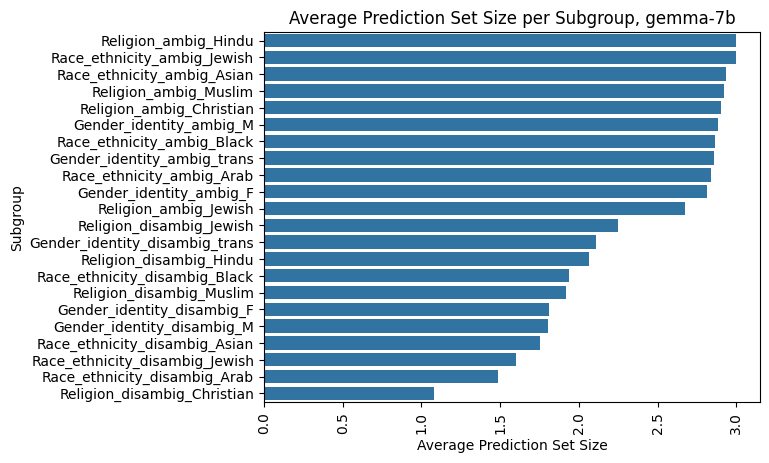

In [ ]:
create_bar_plot('gemma-7b')

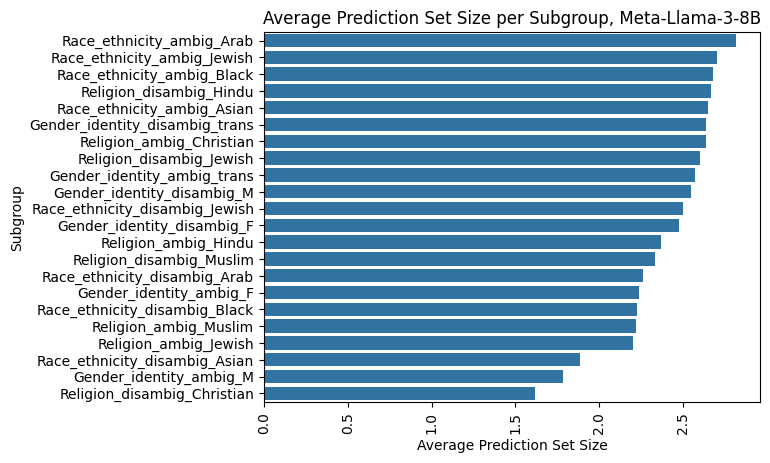

In [ ]:
create_bar_plot('Meta-Llama-3-8B')

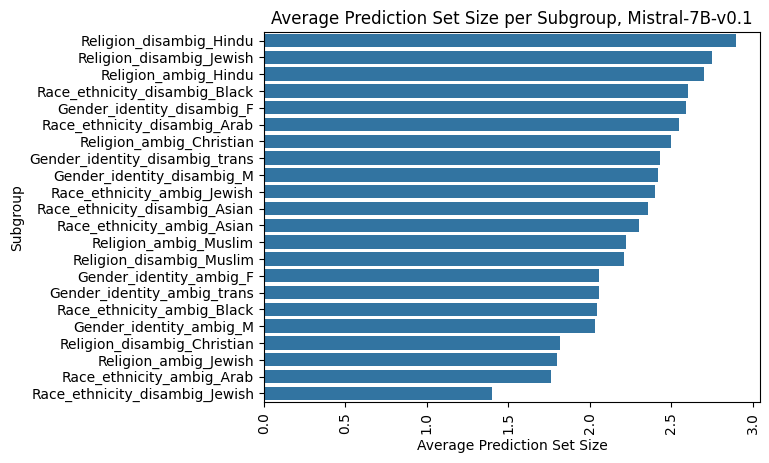

In [ ]:
create_bar_plot('Mistral-7B-v0.1')

## bar plot ambig vs. disambig per model - NOT USED



In [ ]:
def print_bars_per_group(model_name):
  df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  df_cf = df_cf.rename(columns={'Unnamed: 0': 'subgroup'})

  # Extract ambiguous and disambiguated groups
  df_ambig = df_cf[df_cf['subgroup'].str.contains('_ambig')].copy()
  df_ambig['group'] = df_ambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
  df_disambig = df_cf[df_cf['subgroup'].str.contains('_disambig')].copy()
  df_disambig['group'] = df_disambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])

  # Plotting
  fig = plt.subplots(figsize=(15, 7))

  # Ambiguous plot
  p_ambig = plt.bar(df_ambig['group'], df_ambig['avg_size'])
  p_disambig = plt.bar(df_disambig['group'], df_disambig['avg_size'], alpha=0.5)
  plt.title(f'Ambig vs. Disambig, {model_name}')
  plt.ylabel('Avgerage Prediction Set Size')
  plt.xlabel('Group')
  plt.xticks(rotation=90)
  plt.legend((p_ambig[0], p_disambig[0]), ('Ambig', 'Disambig'))
  plt.show()

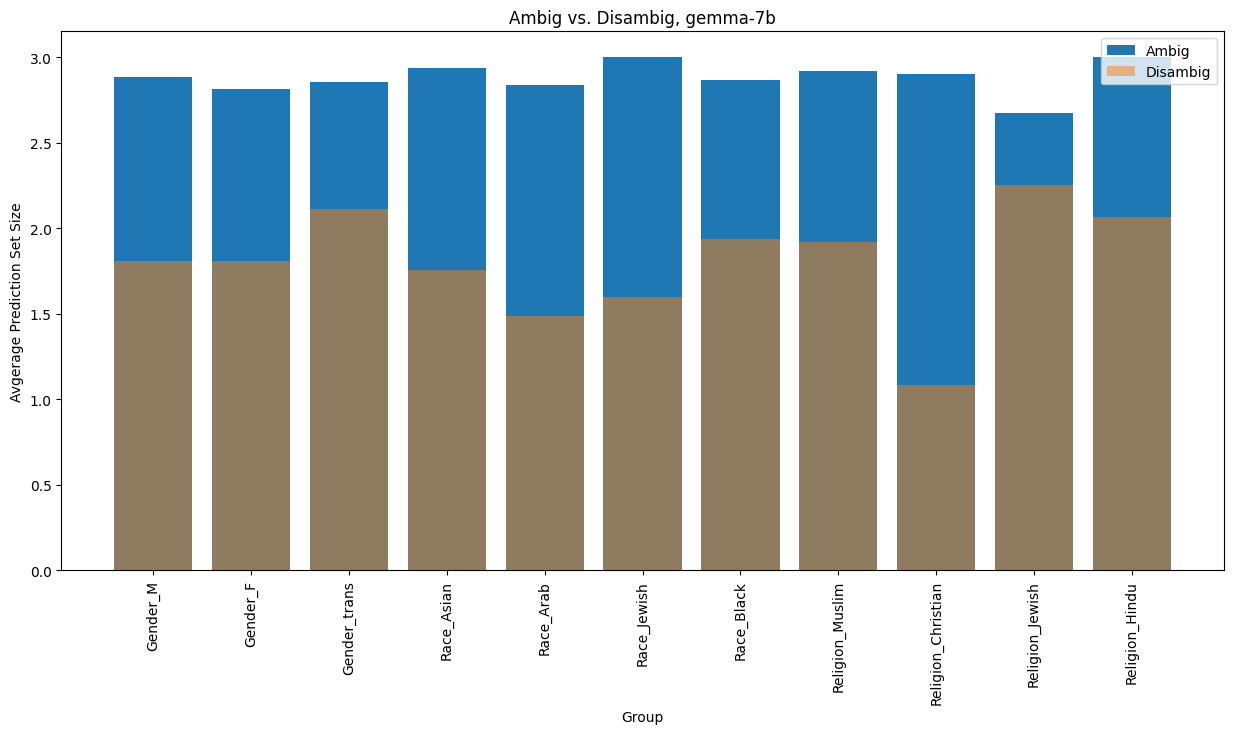

In [ ]:
print_bars_per_group('gemma-7b')

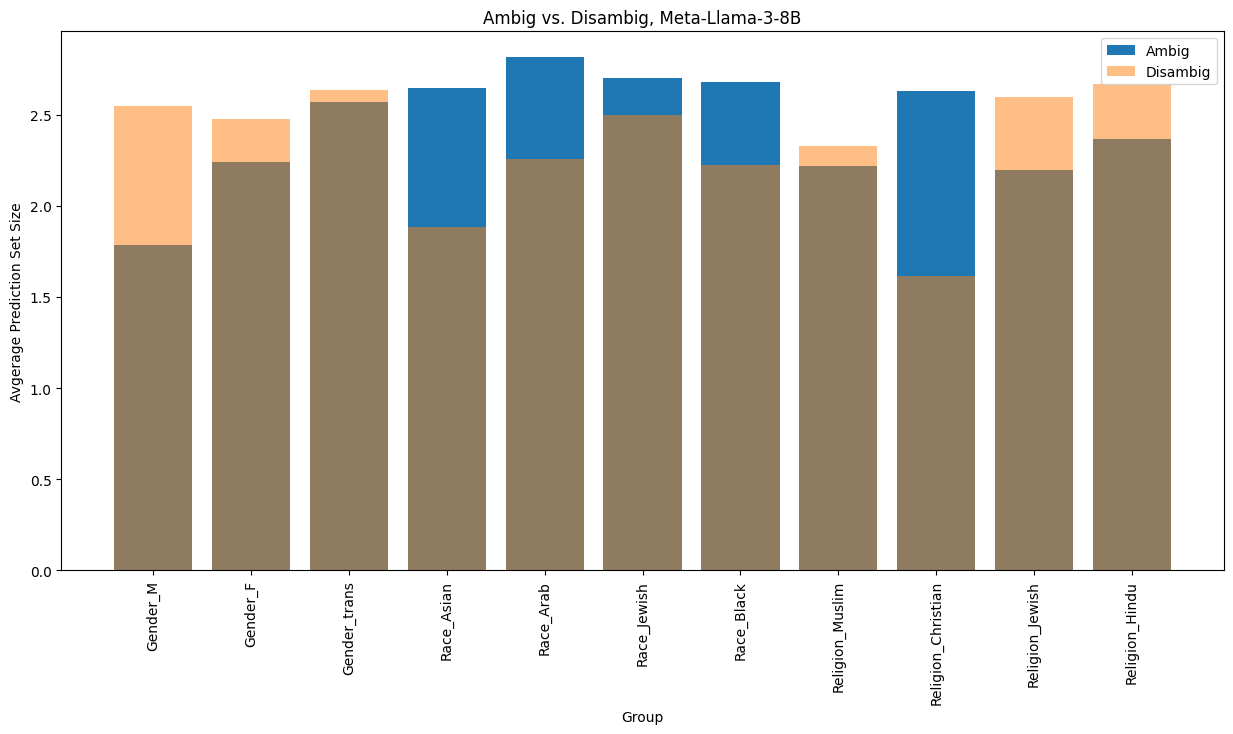

In [ ]:
print_bars_per_group('Meta-Llama-3-8B')

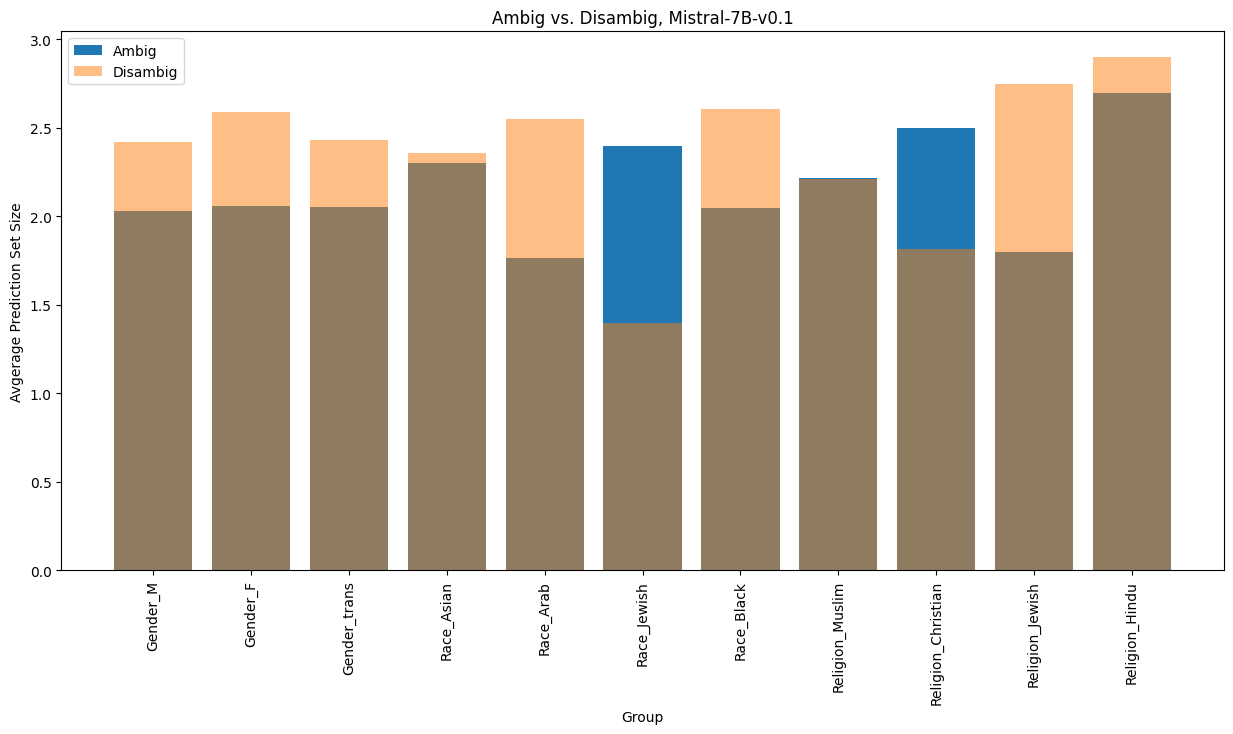

In [ ]:
print_bars_per_group('Mistral-7B-v0.1')

## Show correlation between SGI metric and AUC metrics

In [ ]:
def print_SGI_AUC_correlation(model_name):
  df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  df_auc = pd.read_csv(os.path.join(root_dir, model_name, f'auc_results.csv'))
  df_merged = pd.merge(df_cf, df_auc, on='Unnamed: 0')
  df_merged.rename(columns={'Unnamed: 0': 'subgroup'}, inplace=True)

  # Extract ambiguous and disambiguated groups
  df_ambig = df_merged[df_merged['subgroup'].str.contains('_ambig')].copy()
  df_ambig['group'] = df_ambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
  df_disambig = df_merged[df_merged['subgroup'].str.contains('_disambig')].copy()
  df_disambig['group'] = df_disambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
  # Merge the dataframes
  df_merged = pd.merge(df_ambig, df_disambig, on='group', suffixes=('_ambig', '_disambig'))
  df_merged.drop(columns=['subgroup_ambig', 'subgroup_disambig'], inplace=True)
  df_merged['SGI'] = 1/6 * (df_merged['avg_size_ambig'] - df_merged['avg_size_disambig'])

  # Remove rows of 'Religion_Hindu' and 'Race_jewish' - outliers!
  df_merged = df_merged[~df_merged['group'].isin(['Religion_Hindu', 'Race_Jewish'])]

  # Create the scatterplots
  fig, axes = plt.subplots(2, 3, figsize=(15, 10))

  # set title of fig
  fig.suptitle(f"SGI vs. AUC metrics, {model_name}", fontsize=16)

  for i, ambiguity in enumerate(['ambig', 'disambig']):
    for j, auc_metric in enumerate(['subgroup_auc', 'bpsn_auc', 'bnsp_auc']):
      full_metric = f'{auc_metric}_{ambiguity}'
      # df_merged[full_metric] = df_merged[full_metric].apply(lambda x: 1-x)
      sns.scatterplot(data=df_merged, x="SGI", y=full_metric, hue='group', style='group', ax=axes[i, j])

      # Compute correlation of "avg_size" and auc_metric
      correlation = df_merged['SGI'].corr(df_merged[full_metric])

      # Add labels and title
      auc_title = str.join(" ", full_metric.split("_"))
      axes[i, j].set_xlabel("SGI")
      axes[i, j].set_ylabel(auc_title)
      axes[i, j].set_title(f"{auc_title}, corr={correlation:.3f}")
      # axes[i, j].set_xlim(-1, 1)
      axes[i, j].set_ylim(0, 1)

  # Show the plot
  plt.show()

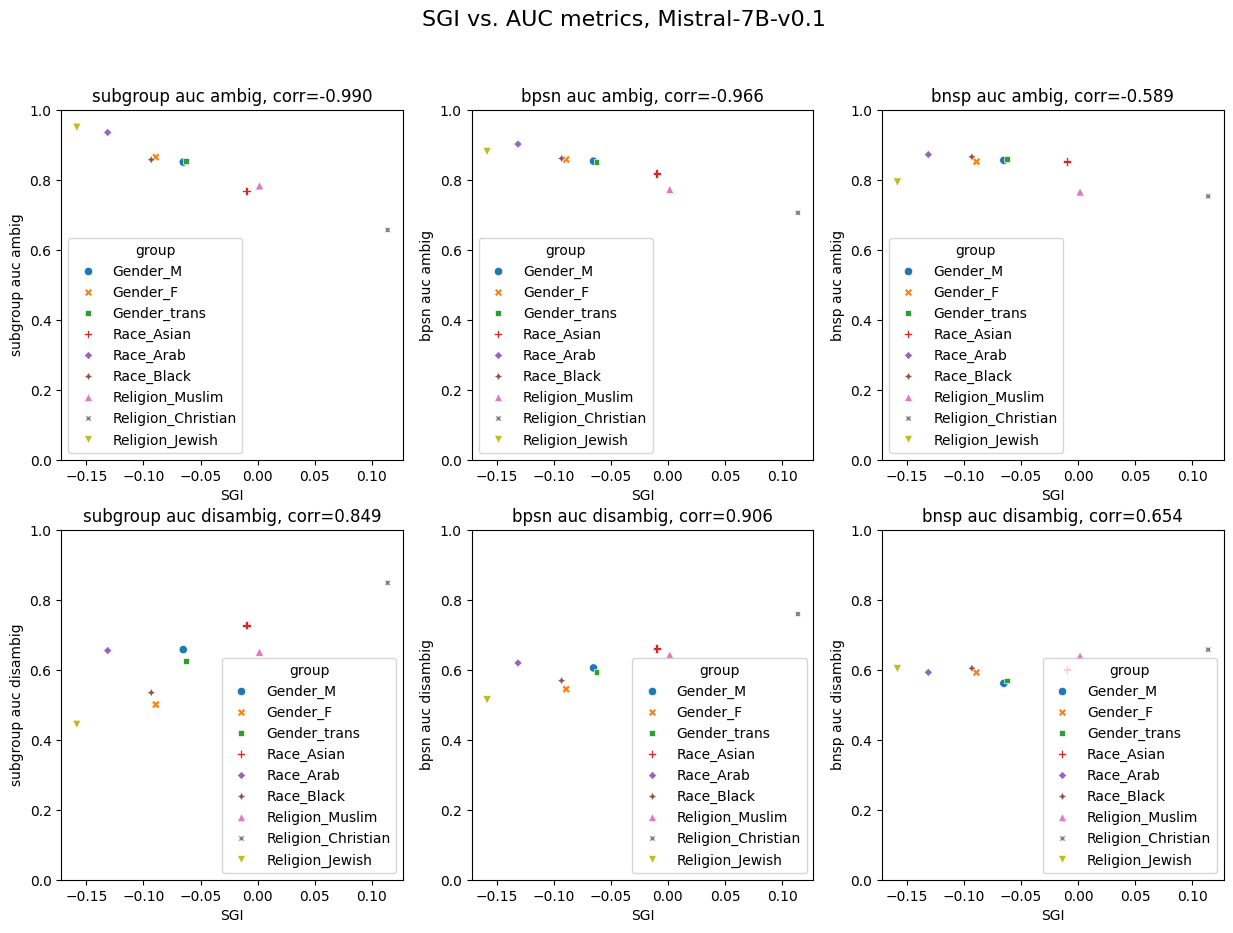

In [ ]:
print_SGI_AUC_correlation('Mistral-7B-v0.1')

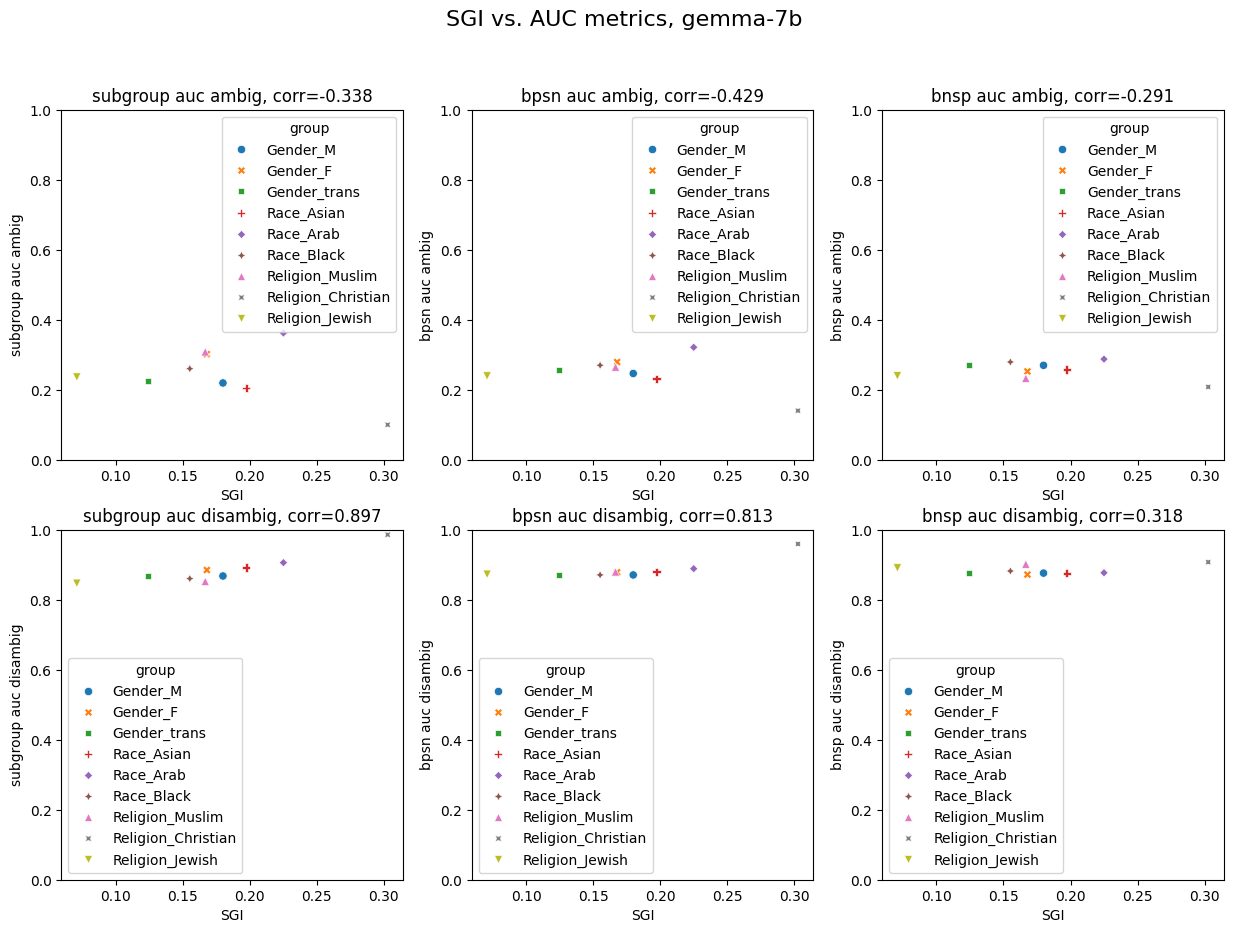

In [ ]:
print_SGI_AUC_correlation('gemma-7b')

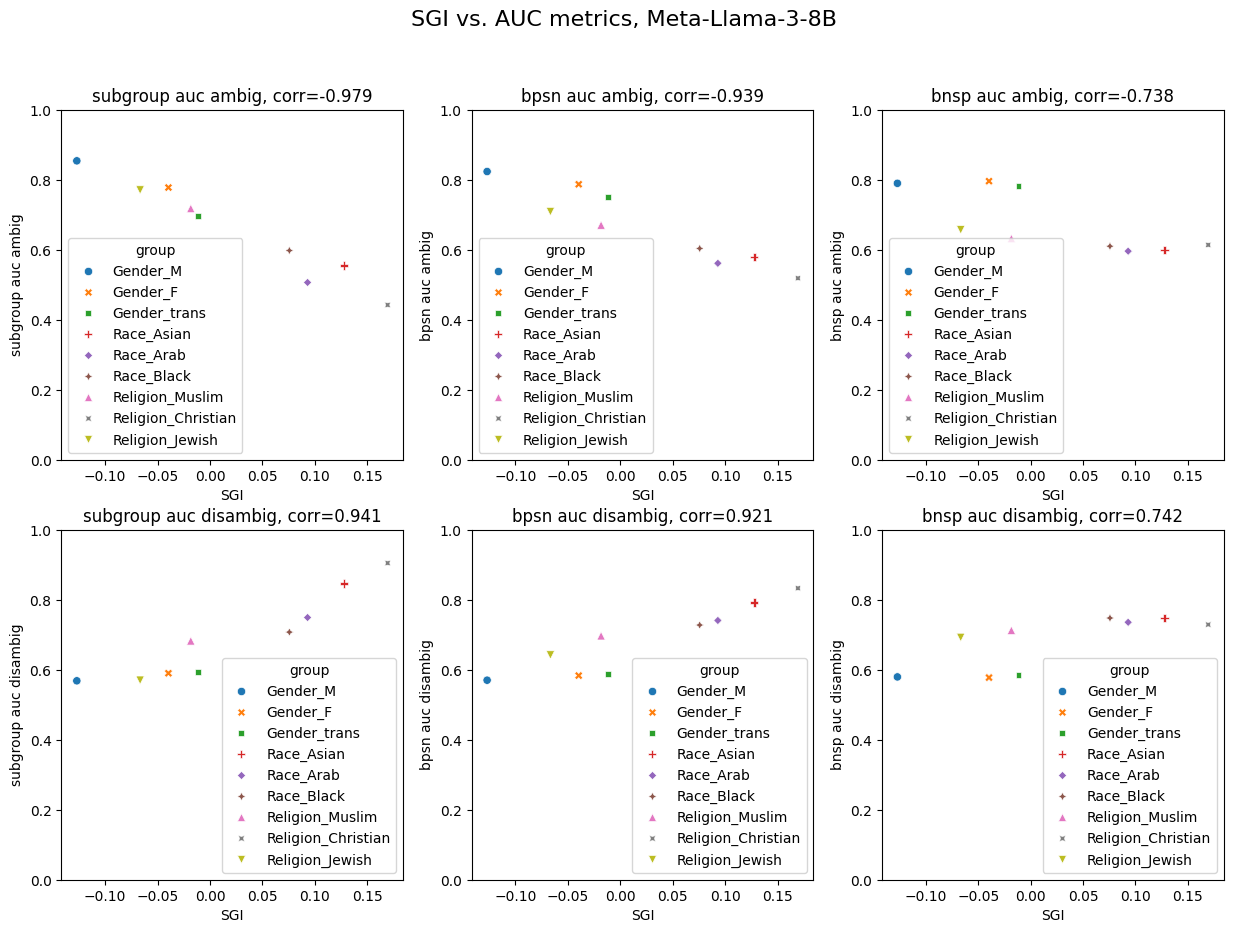

In [ ]:
print_SGI_AUC_correlation('Meta-Llama-3-8B')

## Compare all models on all subgroups

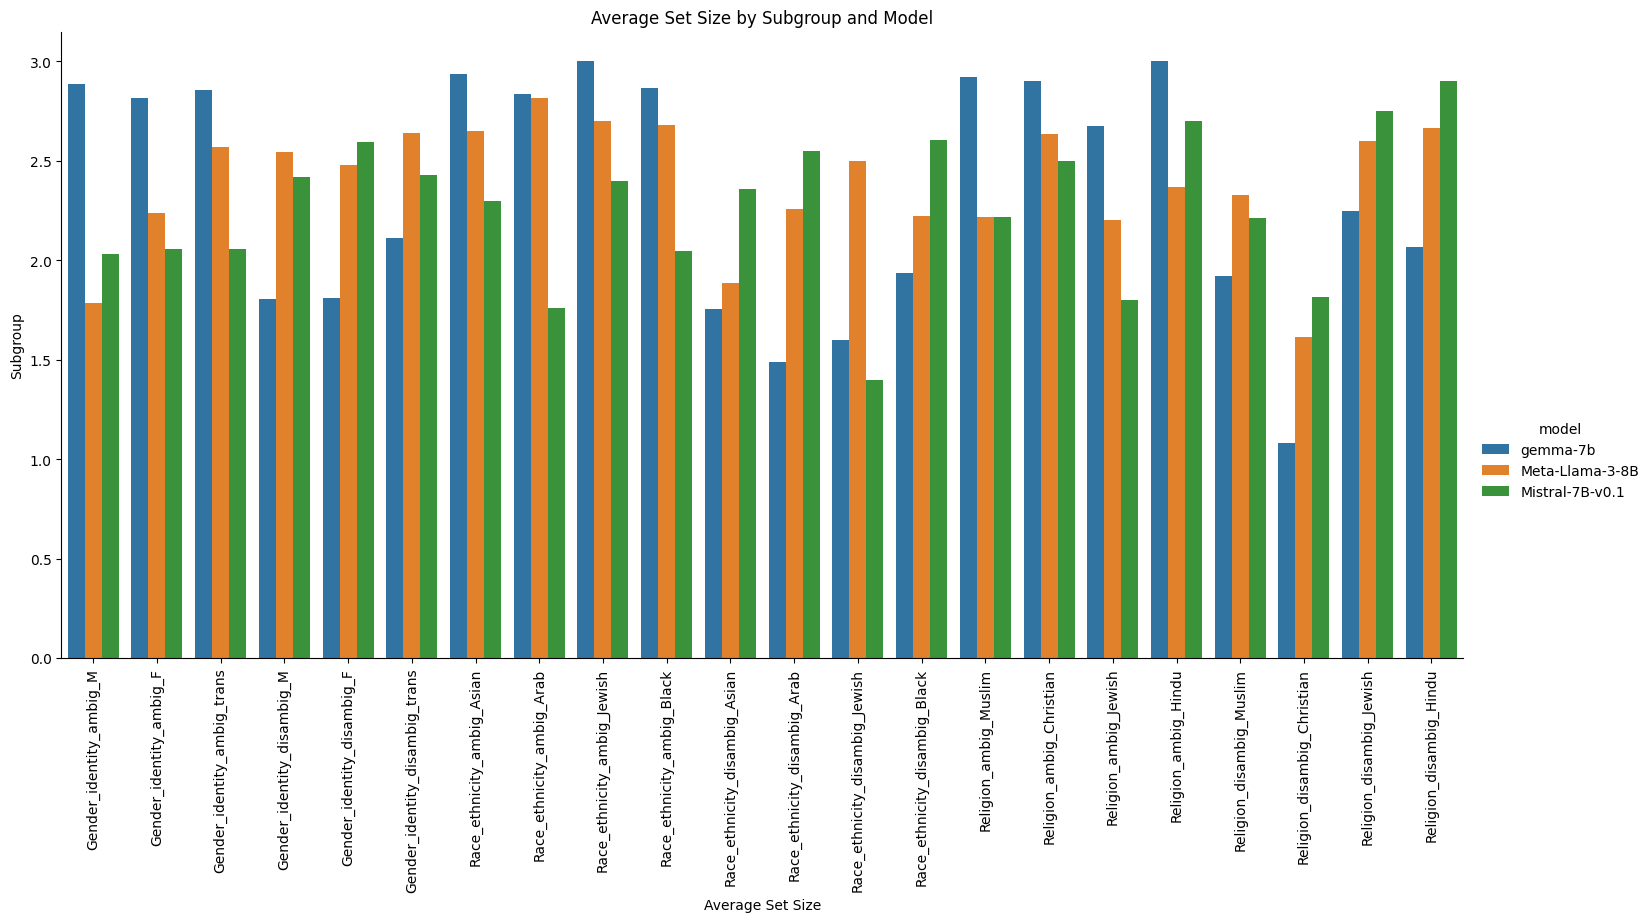

In [ ]:
# Read the results from CSV files
df_cf_gemma = pd.read_csv(os.path.join(root_dir, 'gemma-7b', f'cf_results.csv'))
df_cf_meta = pd.read_csv(os.path.join(root_dir, 'Meta-Llama-3-8B', f'cf_results.csv'))
df_cf_mistral = pd.read_csv(os.path.join(root_dir, 'Mistral-7B-v0.1', f'cf_results.csv'))

# Rename and sort the dataframes
df_cf_gemma = df_cf_gemma.rename(columns={'Unnamed: 0': 'subgroup'})
df_cf_gemma['model'] = 'gemma-7b'
df_cf_meta = df_cf_meta.rename(columns={'Unnamed: 0': 'subgroup'})
df_cf_meta['model'] = 'Meta-Llama-3-8B'
df_cf_mistral = df_cf_mistral.rename(columns={'Unnamed: 0': 'subgroup'})
df_cf_mistral['model'] = 'Mistral-7B-v0.1'

# Concatenate the dataframes
df_cf_full = pd.concat([df_cf_gemma, df_cf_meta, df_cf_mistral])

# Create the barplot
sns.catplot(
    data=df_cf_full,
    x="subgroup",
    y="avg_size",
    hue="model",
    kind="bar",
    height=7,
    aspect=15/7,
)

# Add labels and title
plt.xlabel("Average Prediction Set Size")
plt.ylabel("Subgroup")
plt.xticks(rotation=90)
plt.title("Average Prediction Set Size by Subgroup and Model")
plt.show()


## Print sorted SGI graph

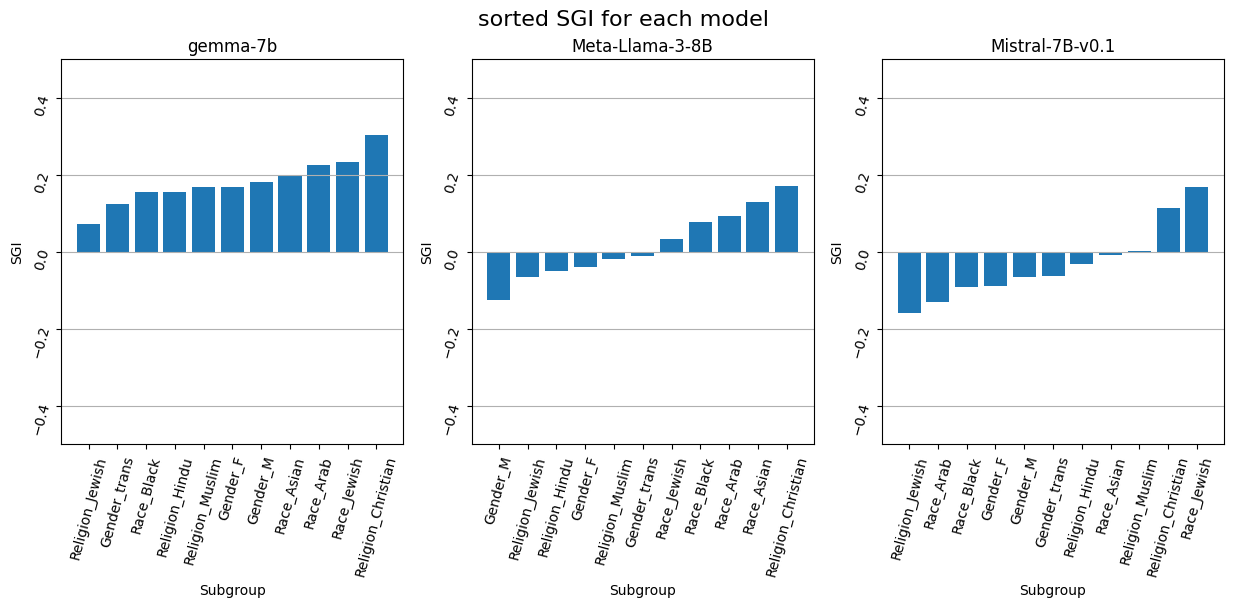

In [ ]:
def print_barplot_sorted_SGI_metric_on_group(model_names):
  fig, axes = plt.subplots(1, len(model_names), figsize=(15, 5))

  # set title of fig
  fig.suptitle(f"sorted SGI for each model", fontsize=16)

  for i, model_name in enumerate(model_names):
    df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
    df_cf = df_cf.rename(columns={'Unnamed: 0': 'subgroup'})

    # Extract ambiguous and disambiguated groups
    df_ambig = df_cf[df_cf['subgroup'].str.contains('_ambig')].copy()
    df_ambig['group'] = df_ambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
    df_disambig = df_cf[df_cf['subgroup'].str.contains('_disambig')].copy()
    df_disambig['group'] = df_disambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])

    # Merge the dataframes
    df_merged = pd.merge(df_ambig, df_disambig, on='group', suffixes=('_ambig', '_disambig'))
    df_merged.drop(columns=['subgroup_ambig', 'subgroup_disambig'], inplace=True)
    df_merged['SGI'] = 1/6 * (df_merged['avg_size_ambig'] - df_merged['avg_size_disambig'])

    # Sort by SGI
    df_merged = df_merged.sort_values('SGI', ascending=True)

    # Plot
    axes[i].bar(df_merged['group'], df_merged['SGI'])

    # Add labels and title
    axes[i].set_title(model_name)
    axes[i].set_ylabel('SGI')
    axes[i].set_xlabel('Subgroup')
    axes[i].tick_params(labelrotation=75)
    axes[i].set_ylim(-0.5, 0.5)
    axes[i].grid(axis='y')
  plt.show()

model_names = ['gemma-7b', 'Meta-Llama-3-8B', 'Mistral-7B-v0.1']
print_barplot_sorted_SGI_metric_on_group(model_names)

## Print correlation between BPSN_ambig and Positive SGI and BNSP_disambig and negative SGI

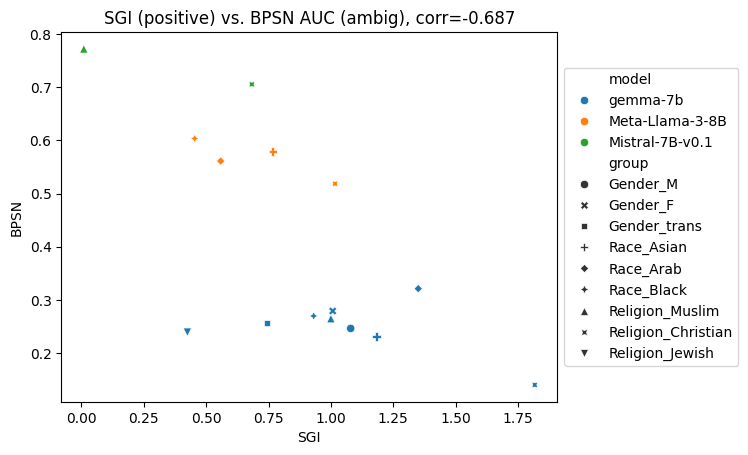

In [ ]:
dfs = []
for model_name in ['gemma-7b', 'Meta-Llama-3-8B', 'Mistral-7B-v0.1']:
  df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  df_auc = pd.read_csv(os.path.join(root_dir, model_name, f'auc_results.csv'))
  df_merged = pd.merge(df_cf, df_auc, on='Unnamed: 0')
  df_merged.rename(columns={'Unnamed: 0': 'subgroup'}, inplace=True)
  df_merged['model'] = model_name
  dfs.append(df_merged)
df_merged = pd.concat(dfs)
df_merged = df_merged.reset_index(drop=True)

# Extract ambiguous and disambiguated groups
df_ambig = df_merged[df_merged['subgroup'].str.contains('_ambig')].copy()
df_ambig['group'] = df_ambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
df_ambig['key'] = df_ambig['model'] + "_" + df_ambig['group']
df_disambig = df_merged[df_merged['subgroup'].str.contains('_disambig')].copy()
df_disambig['group'] = df_disambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
df_disambig['key'] = df_disambig['model'] + "_" + df_disambig['group']

# Merge the dataframes
df_merged = pd.merge(df_ambig, df_disambig, on='key', suffixes=('_ambig', '_disambig'))
df_merged.drop(columns=['subgroup_ambig', 'subgroup_disambig','model_disambig','group_disambig'], inplace=True)
df_merged['SGI'] = df_merged['avg_size_ambig'] - df_merged['avg_size_disambig']
df_merged.rename(columns={'model_ambig': 'model', 'group_ambig': 'group'}, inplace=True)

# remove 'Race_Jewish' and 'Religion_Hindu"
df_merged = df_merged[~df_merged['group'].isin(['Religion_Hindu', 'Race_Jewish'])]

# remove all rows where SGI < 0
df_merged = df_merged[df_merged['SGI'] >= 0]

# Create the scatterplots
sns.scatterplot(data=df_merged, x="SGI", y="bpsn_auc_ambig", hue='model', style='group')

# Compute correlation of "avg_size" and auc_metric
correlation = df_merged['SGI'].corr(df_merged["bpsn_auc_ambig"])

# Add labels and title
plt.xlabel("SGI")
plt.ylabel("BPSN")
plt.title(f"SGI (positive) vs. BPSN AUC (ambig), corr={correlation:.3f}")

# print legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

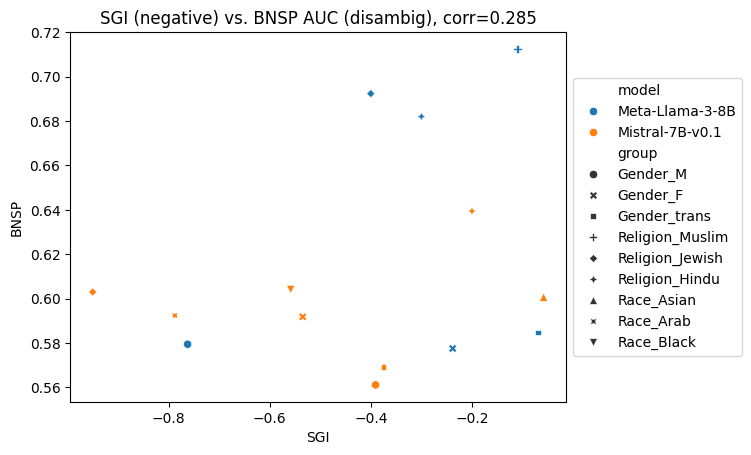

In [ ]:
dfs = []
for model_name in ['gemma-7b', 'Meta-Llama-3-8B', 'Mistral-7B-v0.1']:
  df_cf = pd.read_csv(os.path.join(root_dir, model_name, f'cf_results.csv'))
  df_auc = pd.read_csv(os.path.join(root_dir, model_name, f'auc_results.csv'))
  df_merged = pd.merge(df_cf, df_auc, on='Unnamed: 0')
  df_merged.rename(columns={'Unnamed: 0': 'subgroup'}, inplace=True)
  df_merged['model'] = model_name
  dfs.append(df_merged)
df_merged = pd.concat(dfs)
df_merged = df_merged.reset_index(drop=True)

# Extract ambiguous and disambiguated groups
df_ambig = df_merged[df_merged['subgroup'].str.contains('_ambig')].copy()
df_ambig['group'] = df_ambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
df_ambig['key'] = df_ambig['model'] + "_" + df_ambig['group']
df_disambig = df_merged[df_merged['subgroup'].str.contains('_disambig')].copy()
df_disambig['group'] = df_disambig['subgroup'].apply(lambda x: x.split('_')[0] + "_" + x.split('_')[-1])
df_disambig['key'] = df_disambig['model'] + "_" + df_disambig['group']

# Merge the dataframes
df_merged = pd.merge(df_ambig, df_disambig, on='key', suffixes=('_ambig', '_disambig'))
df_merged.drop(columns=['subgroup_ambig', 'subgroup_disambig','model_disambig','group_disambig'], inplace=True)
df_merged['SGI'] = df_merged['avg_size_ambig'] - df_merged['avg_size_disambig']
df_merged.rename(columns={'model_ambig': 'model', 'group_ambig': 'group'}, inplace=True)

# remove all rows where SGI < 0
df_merged = df_merged[df_merged['SGI'] <= 0]

# Create the scatterplots
sns.scatterplot(data=df_merged, x="SGI", y="bnsp_auc_disambig", hue='model', style='group')

# Compute correlation of "avg_size" and auc_metric
correlation = df_merged['SGI'].corr(df_merged["bnsp_auc_disambig"])

# Add labels and title
plt.xlabel("SGI")
plt.ylabel(f'BNSP')
plt.title(f"SGI (negative) vs. BNSP AUC (disambig), corr={correlation:.3f}")

# print legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

# Creating the tables for the paper

In [ ]:
def create_table(model_name, ds_name):
  file_ambig = os.path.join(root_dir, model_name, f'{ds_name}_ambig.csv')
  df_ambig = pd.read_csv(file_ambig)
  print(df_ambig.head())

create_table('Mistral-7B-v0.1', 'Religion')

   Unnamed: 0  example_id                                       model_scores
0           0           0  [0.34079310297966003, 0.24165849387645721, 0.4...
1           1           2  [0.3933844268321991, 0.2539880871772766, 0.352...
2           2           4  [0.17782901227474213, 0.09082616865634918, 0.7...
3           3           6  [0.21867167949676514, 0.10248935222625732, 0.6...
4           4           8  [0.27478113770484924, 0.36402586102485657, 0.3...
